# Model Performance Test


In [18]:
from dtsp.dataset import walk_forward_split, Seq2SeqDataSet, SimpleSeq2SeqDataSet, SimpleWaveNetDataSet
from dtsp.models import Seq2Seq, SimpleSeq2Seq, SimpleWaveNet
from torch.utils.data import DataLoader
from torch.utils.data import Subset, DataLoader
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from pathlib import Path
import shutil
import seaborn as sns

def plot_attentions(attns):
    if attns.ndim == 4:
        assert attns.shape[0] == 1
        attns = attns.squeeze(0)
    if isinstance(attns, torch.Tensor):
        attns = attns.detach().numpy()
    n_head = attns.shape[1]
    
    base_size = 12
    
    hight = attns.shape[0]
    wide = attns.shape[2]
    for i in range(n_head):
        plt.figure(figsize=(16, hight / wide * 16))
        sns.heatmap(attns[:, i, :])
        plt.title(f"Attention {i}")
        plt.xlabel('history')
        plt.ylabel('prediction')

%matplotlib inline

In [2]:
torch.__version__

'1.3.0'

## 1. prepare dataset

In [3]:
df = pd.read_csv('./data.csv', index_col='date_time', parse_dates=['date_time'])
series = df.values
month = df.index.month.values
df.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
date_time,,,,,,,,,,,,,,,,,,,,
1998-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0


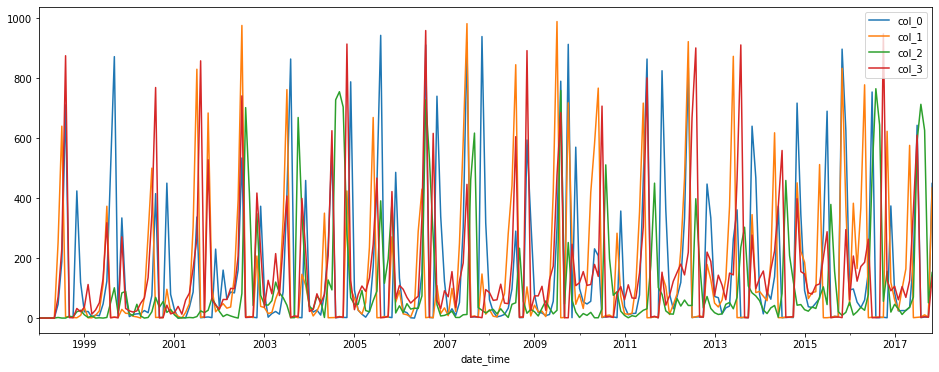

In [4]:
df.iloc[:, :4].plot(figsize=(16, 6))

**Target**

In [14]:
n_test = 12
n_val = 12
enc_lens = 72
dec_lens = 12
batch_size = 8
epochs = 50

## 1. Simple Seq2Seq Model

In [6]:
dataset = SimpleSeq2SeqDataSet(series, enc_lens, dec_lens)
idxes = list(range(len(dataset)))
train_idxes, _idxes = walk_forward_split(idxes, enc_lens, dec_lens, test_size=n_test + n_val)
valid_idxes, test_idxes = walk_forward_split(_idxes, enc_lens, dec_lens, test_size=n_test)

trn_set = Subset(dataset, train_idxes)
val_set = Subset(dataset, valid_idxes)
test_set = Subset(dataset, test_idxes)
trn_ld = DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_ld = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_ld = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [7]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.2,
        'hidden_size': 72,
        'teacher_forcing_rate': 0.5,
        'learning_rate': 0.001,
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = SimpleSeq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 8 / 17, loss 0.997:  29%|██▉       | 5/17 [00:00<00:00, 41.29it/s]

epoch 1 / 50: train loss 1.066 val loss 1.198 RMSE 181.816


batch 7 / 17, loss 0.719:  24%|██▎       | 4/17 [00:00<00:00, 39.34it/s]

epoch 2 / 50: train loss 0.944 val loss 0.989 RMSE 169.967


batch 7 / 17, loss 1.018:  24%|██▎       | 4/17 [00:00<00:00, 33.80it/s]

epoch 3 / 50: train loss 0.832 val loss 0.954 RMSE 165.981


batch 6 / 17, loss 0.879:  24%|██▎       | 4/17 [00:00<00:00, 33.25it/s]

epoch 4 / 50: train loss 0.827 val loss 0.945 RMSE 165.116


batch 5 / 17, loss 0.914:  18%|█▊        | 3/17 [00:00<00:00, 23.76it/s]

epoch 5 / 50: train loss 0.811 val loss 0.938 RMSE 164.710


batch 3 / 17, loss 0.695:  12%|█▏        | 2/17 [00:00<00:00, 20.00it/s]

epoch 6 / 50: train loss 0.786 val loss 0.904 RMSE 161.015


batch 5 / 17, loss 0.631:  18%|█▊        | 3/17 [00:00<00:00, 29.59it/s]

epoch 7 / 50: train loss 0.736 val loss 0.867 RMSE 156.996


batch 4 / 17, loss 0.661:  18%|█▊        | 3/17 [00:00<00:00, 25.24it/s]

epoch 8 / 50: train loss 0.700 val loss 0.836 RMSE 152.628


batch 5 / 17, loss 1.008:  18%|█▊        | 3/17 [00:00<00:00, 29.20it/s]

epoch 9 / 50: train loss 0.710 val loss 0.883 RMSE 157.743


batch 4 / 17, loss 0.786:  18%|█▊        | 3/17 [00:00<00:00, 26.13it/s]

epoch 10 / 50: train loss 0.741 val loss 0.963 RMSE 163.594


batch 5 / 17, loss 0.663:  18%|█▊        | 3/17 [00:00<00:00, 25.70it/s]

epoch 11 / 50: train loss 0.708 val loss 0.843 RMSE 153.685


batch 5 / 17, loss 0.620:  24%|██▎       | 4/17 [00:00<00:00, 30.74it/s]

epoch 12 / 50: train loss 0.677 val loss 0.866 RMSE 155.367


batch 6 / 17, loss 0.624:  24%|██▎       | 4/17 [00:00<00:00, 32.07it/s]

epoch 13 / 50: train loss 0.637 val loss 0.811 RMSE 150.463


batch 6 / 17, loss 0.663:  24%|██▎       | 4/17 [00:00<00:00, 34.35it/s]

epoch 14 / 50: train loss 0.633 val loss 0.795 RMSE 148.144


batch 7 / 17, loss 0.540:  24%|██▎       | 4/17 [00:00<00:00, 36.08it/s]

epoch 15 / 50: train loss 0.616 val loss 0.803 RMSE 148.903


batch 7 / 17, loss 0.625:  24%|██▎       | 4/17 [00:00<00:00, 33.21it/s]

epoch 16 / 50: train loss 0.596 val loss 0.785 RMSE 147.482


batch 4 / 17, loss 0.607:  24%|██▎       | 4/17 [00:00<00:00, 29.02it/s]

epoch 17 / 50: train loss 0.610 val loss 0.775 RMSE 146.145


batch 5 / 17, loss 0.506:  18%|█▊        | 3/17 [00:00<00:00, 25.01it/s]

epoch 18 / 50: train loss 0.569 val loss 0.771 RMSE 146.426


batch 7 / 17, loss 0.585:  24%|██▎       | 4/17 [00:00<00:00, 33.46it/s]

epoch 19 / 50: train loss 0.562 val loss 0.766 RMSE 145.730


batch 7 / 17, loss 0.618:  24%|██▎       | 4/17 [00:00<00:00, 33.73it/s]

epoch 20 / 50: train loss 0.551 val loss 0.830 RMSE 153.713


batch 5 / 17, loss 0.523:  18%|█▊        | 3/17 [00:00<00:00, 23.79it/s]

epoch 21 / 50: train loss 0.598 val loss 0.764 RMSE 145.583


batch 3 / 17, loss 0.634:  12%|█▏        | 2/17 [00:00<00:00, 17.33it/s]

epoch 22 / 50: train loss 0.561 val loss 0.758 RMSE 145.990


batch 5 / 17, loss 0.494:  12%|█▏        | 2/17 [00:00<00:00, 19.07it/s]

epoch 23 / 50: train loss 0.583 val loss 0.767 RMSE 145.526


batch 6 / 17, loss 0.390:  18%|█▊        | 3/17 [00:00<00:00, 27.34it/s]

epoch 24 / 50: train loss 0.559 val loss 0.747 RMSE 144.060


batch 5 / 17, loss 0.467:  18%|█▊        | 3/17 [00:00<00:00, 26.58it/s]

epoch 25 / 50: train loss 0.523 val loss 0.755 RMSE 145.094


batch 7 / 17, loss 0.442:  24%|██▎       | 4/17 [00:00<00:00, 36.09it/s]

epoch 26 / 50: train loss 0.527 val loss 0.734 RMSE 143.263


batch 4 / 17, loss 0.514:  18%|█▊        | 3/17 [00:00<00:00, 21.80it/s]

epoch 27 / 50: train loss 0.517 val loss 0.732 RMSE 142.764


batch 7 / 17, loss 0.548:  24%|██▎       | 4/17 [00:00<00:00, 37.23it/s]

epoch 28 / 50: train loss 0.492 val loss 0.731 RMSE 143.060


batch 4 / 17, loss 0.419:  18%|█▊        | 3/17 [00:00<00:00, 29.83it/s]

epoch 29 / 50: train loss 0.514 val loss 0.729 RMSE 142.670


batch 6 / 17, loss 0.419:  24%|██▎       | 4/17 [00:00<00:00, 31.46it/s]

epoch 30 / 50: train loss 0.519 val loss 0.732 RMSE 143.050


batch 5 / 17, loss 0.440:  18%|█▊        | 3/17 [00:00<00:00, 29.61it/s]

epoch 31 / 50: train loss 0.483 val loss 0.717 RMSE 141.539


batch 4 / 17, loss 0.687:  18%|█▊        | 3/17 [00:00<00:00, 25.48it/s]

epoch 32 / 50: train loss 0.485 val loss 0.715 RMSE 140.915


batch 7 / 17, loss 0.543:  24%|██▎       | 4/17 [00:00<00:00, 34.81it/s]

epoch 33 / 50: train loss 0.502 val loss 0.719 RMSE 141.166


batch 6 / 17, loss 0.399:  24%|██▎       | 4/17 [00:00<00:00, 34.81it/s]

epoch 34 / 50: train loss 0.495 val loss 0.716 RMSE 141.253


batch 7 / 17, loss 0.586:  24%|██▎       | 4/17 [00:00<00:00, 39.33it/s]

epoch 35 / 50: train loss 0.481 val loss 0.715 RMSE 141.098


batch 8 / 17, loss 0.426:  29%|██▉       | 5/17 [00:00<00:00, 42.04it/s]

epoch 36 / 50: train loss 0.482 val loss 0.703 RMSE 139.735


batch 5 / 17, loss 0.380:  24%|██▎       | 4/17 [00:00<00:00, 29.65it/s]

epoch 37 / 50: train loss 0.468 val loss 0.705 RMSE 140.004


batch 7 / 17, loss 0.433:  24%|██▎       | 4/17 [00:00<00:00, 37.85it/s]

epoch 38 / 50: train loss 0.486 val loss 0.710 RMSE 140.622


batch 7 / 17, loss 0.613:  24%|██▎       | 4/17 [00:00<00:00, 36.85it/s]

epoch 39 / 50: train loss 0.493 val loss 0.696 RMSE 139.247


batch 2 / 17, loss 0.560:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 40 / 50: train loss 0.481 val loss 0.696 RMSE 139.064


batch 5 / 17, loss 0.529:  24%|██▎       | 4/17 [00:00<00:00, 32.56it/s]

epoch 41 / 50: train loss 0.466 val loss 0.693 RMSE 138.641


batch 7 / 17, loss 0.557:  24%|██▎       | 4/17 [00:00<00:00, 38.68it/s]

epoch 42 / 50: train loss 0.432 val loss 0.690 RMSE 138.481


batch 7 / 17, loss 0.477:  24%|██▎       | 4/17 [00:00<00:00, 37.92it/s]

epoch 43 / 50: train loss 0.468 val loss 0.688 RMSE 138.105


batch 7 / 17, loss 0.497:  24%|██▎       | 4/17 [00:00<00:00, 37.84it/s]

epoch 44 / 50: train loss 0.469 val loss 0.690 RMSE 138.274


batch 5 / 17, loss 0.472:  18%|█▊        | 3/17 [00:00<00:00, 24.57it/s]

epoch 45 / 50: train loss 0.476 val loss 0.688 RMSE 138.221


batch 4 / 17, loss 0.392:  18%|█▊        | 3/17 [00:00<00:00, 22.09it/s]

epoch 46 / 50: train loss 0.467 val loss 0.686 RMSE 138.028


batch 5 / 17, loss 0.410:  18%|█▊        | 3/17 [00:00<00:00, 28.42it/s]

epoch 47 / 50: train loss 0.435 val loss 0.683 RMSE 137.671


batch 6 / 17, loss 0.391:  24%|██▎       | 4/17 [00:00<00:00, 32.79it/s]

epoch 48 / 50: train loss 0.465 val loss 0.685 RMSE 137.997


batch 2 / 17, loss 0.431:  12%|█▏        | 2/17 [00:00<00:01, 11.70it/s]

epoch 49 / 50: train loss 0.429 val loss 0.683 RMSE 137.749


batch 17 / 17, loss 0.449: 100%|██████████| 17/17 [00:00<00:00, 18.05it/s]


epoch 50 / 50: train loss 0.452 val loss 0.682 RMSE 137.589
best model save in /home/zhouzr/project/Deep-Time-Series-Prediction/notebooks/logs/SimpleSeq2Seq_epoch_50_0.682.pkl


In [11]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.476, valid loss: 0.682, test loss :0.725, test RMSE :141.546, 


## 2. Seq2Seq(Attention 0)

In [12]:
dataset = Seq2SeqDataSet(series, enc_lens, dec_lens, categorical_var=month)
idxes = list(range(len(dataset)))
train_idxes, _idxes = walk_forward_split(idxes, enc_lens, dec_lens, test_size=n_test + n_val)
valid_idxes, test_idxes = walk_forward_split(_idxes, enc_lens, dec_lens, test_size=n_test)

trn_set = Subset(dataset, train_idxes)
val_set = Subset(dataset, valid_idxes)
test_set = Subset(dataset, test_idxes)
trn_ld = DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_ld = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_ld = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [15]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.1,
        'hidden_size': 128,
        'teacher_forcing_rate': 0.5,
        'n_head': 4,
        'use_attn': False,
        'trans_hidden_size': 4,
        'trans_continuous_var': None,
        'trans_category_var': [(13, 2)],
        'trans_bidirectional': True,
        'trans_rnn_type': 'LSTM',
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = Seq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 1 / 17, loss 1.090:   6%|▌         | 1/17 [00:00<00:01,  9.74it/s]

epoch 1 / 50: train loss 1.037 val loss 1.074 RMSE 173.898
create model path: /home/zhouzr/project/Deep-Time-Series-Prediction/notebooks/logs


batch 2 / 17, loss 0.822:   6%|▌         | 1/17 [00:00<00:01,  9.70it/s]

epoch 2 / 50: train loss 0.888 val loss 1.027 RMSE 170.436


batch 2 / 17, loss 0.905:  12%|█▏        | 2/17 [00:00<00:00, 15.03it/s]

epoch 3 / 50: train loss 0.805 val loss 0.937 RMSE 164.248


batch 1 / 17, loss 0.757:   6%|▌         | 1/17 [00:00<00:01,  9.85it/s]

epoch 4 / 50: train loss 0.770 val loss 0.916 RMSE 162.628


batch 2 / 17, loss 0.802:  12%|█▏        | 2/17 [00:00<00:01, 11.93it/s]

epoch 5 / 50: train loss 0.764 val loss 0.911 RMSE 162.139


batch 1 / 17, loss 0.730:   6%|▌         | 1/17 [00:00<00:02,  6.59it/s]

epoch 6 / 50: train loss 0.730 val loss 0.870 RMSE 157.458


batch 3 / 17, loss 0.540:  12%|█▏        | 2/17 [00:00<00:00, 17.25it/s]

epoch 7 / 50: train loss 0.697 val loss 0.848 RMSE 155.354


batch 3 / 17, loss 0.531:  12%|█▏        | 2/17 [00:00<00:00, 16.62it/s]

epoch 8 / 50: train loss 0.703 val loss 0.826 RMSE 151.696


batch 1 / 17, loss 0.663:   6%|▌         | 1/17 [00:00<00:01,  8.77it/s]

epoch 9 / 50: train loss 0.656 val loss 0.868 RMSE 156.430


batch 1 / 17, loss 0.555:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 10 / 50: train loss 0.618 val loss 0.802 RMSE 149.253


batch 2 / 17, loss 0.592:  12%|█▏        | 2/17 [00:00<00:01, 12.87it/s]

epoch 11 / 50: train loss 0.615 val loss 0.779 RMSE 146.918


batch 2 / 17, loss 0.693:  12%|█▏        | 2/17 [00:00<00:01, 12.36it/s]

epoch 12 / 50: train loss 0.628 val loss 0.857 RMSE 153.187


batch 2 / 17, loss 0.664:  12%|█▏        | 2/17 [00:00<00:01, 12.58it/s]

epoch 13 / 50: train loss 0.612 val loss 0.783 RMSE 146.748


batch 2 / 17, loss 0.608:  12%|█▏        | 2/17 [00:00<00:01, 14.10it/s]

epoch 14 / 50: train loss 0.597 val loss 0.770 RMSE 146.714


batch 3 / 17, loss 0.448:  12%|█▏        | 2/17 [00:00<00:00, 16.62it/s]

epoch 15 / 50: train loss 0.539 val loss 0.779 RMSE 147.610


batch 3 / 17, loss 0.611:  12%|█▏        | 2/17 [00:00<00:00, 19.03it/s]

epoch 16 / 50: train loss 0.534 val loss 0.751 RMSE 144.112


batch 2 / 17, loss 0.546:  12%|█▏        | 2/17 [00:00<00:01, 13.53it/s]

epoch 17 / 50: train loss 0.541 val loss 0.721 RMSE 142.262


batch 3 / 17, loss 0.434:  12%|█▏        | 2/17 [00:00<00:00, 18.91it/s]

epoch 18 / 50: train loss 0.507 val loss 0.701 RMSE 139.051


batch 1 / 17, loss 0.472:   6%|▌         | 1/17 [00:00<00:01,  8.56it/s]

epoch 19 / 50: train loss 0.495 val loss 0.691 RMSE 137.682


batch 2 / 17, loss 0.355:  12%|█▏        | 2/17 [00:00<00:01, 12.91it/s]

epoch 20 / 50: train loss 0.477 val loss 0.718 RMSE 139.787


batch 2 / 17, loss 0.394:  12%|█▏        | 2/17 [00:00<00:00, 15.03it/s]

epoch 21 / 50: train loss 0.481 val loss 0.675 RMSE 136.017


batch 2 / 17, loss 0.493:  12%|█▏        | 2/17 [00:00<00:01, 14.79it/s]

epoch 22 / 50: train loss 0.463 val loss 0.672 RMSE 135.978


batch 2 / 17, loss 0.406:  12%|█▏        | 2/17 [00:00<00:01, 12.97it/s]

epoch 23 / 50: train loss 0.442 val loss 0.648 RMSE 132.869


batch 2 / 17, loss 0.415:  12%|█▏        | 2/17 [00:00<00:01, 14.29it/s]

epoch 24 / 50: train loss 0.427 val loss 0.644 RMSE 132.837


batch 3 / 17, loss 0.346:  12%|█▏        | 2/17 [00:00<00:00, 15.15it/s]

epoch 25 / 50: train loss 0.397 val loss 0.649 RMSE 134.476


batch 3 / 17, loss 0.334:  12%|█▏        | 2/17 [00:00<00:00, 15.28it/s]

epoch 26 / 50: train loss 0.410 val loss 0.608 RMSE 128.912


batch 3 / 17, loss 0.427:  12%|█▏        | 2/17 [00:00<00:00, 16.51it/s]

epoch 27 / 50: train loss 0.387 val loss 0.638 RMSE 132.981


batch 3 / 17, loss 0.316:  12%|█▏        | 2/17 [00:00<00:00, 15.46it/s]

epoch 28 / 50: train loss 0.371 val loss 0.609 RMSE 129.418


batch 3 / 17, loss 0.318:  12%|█▏        | 2/17 [00:00<00:00, 15.50it/s]

epoch 29 / 50: train loss 0.352 val loss 0.603 RMSE 127.669


batch 3 / 17, loss 0.285:  12%|█▏        | 2/17 [00:00<00:00, 18.08it/s]

epoch 30 / 50: train loss 0.363 val loss 0.580 RMSE 124.874


batch 3 / 17, loss 0.286:  12%|█▏        | 2/17 [00:00<00:01, 14.90it/s]

epoch 31 / 50: train loss 0.349 val loss 0.568 RMSE 122.965


batch 1 / 17, loss 0.484:   6%|▌         | 1/17 [00:00<00:01,  8.30it/s]

epoch 32 / 50: train loss 0.334 val loss 0.561 RMSE 121.764


batch 3 / 17, loss 0.271:  12%|█▏        | 2/17 [00:00<00:00, 15.18it/s]

epoch 33 / 50: train loss 0.335 val loss 0.548 RMSE 119.421


batch 2 / 17, loss 0.287:  12%|█▏        | 2/17 [00:00<00:01, 11.92it/s]

epoch 34 / 50: train loss 0.321 val loss 0.543 RMSE 118.831


batch 2 / 17, loss 0.255:  12%|█▏        | 2/17 [00:00<00:01, 14.12it/s]

epoch 35 / 50: train loss 0.317 val loss 0.530 RMSE 117.425


batch 2 / 17, loss 0.333:   6%|▌         | 1/17 [00:00<00:01,  9.17it/s]

epoch 36 / 50: train loss 0.312 val loss 0.533 RMSE 117.512


batch 2 / 17, loss 0.310:  12%|█▏        | 2/17 [00:00<00:01, 12.29it/s]

epoch 37 / 50: train loss 0.297 val loss 0.528 RMSE 116.578


batch 2 / 17, loss 0.246:  12%|█▏        | 2/17 [00:00<00:01, 10.98it/s]

epoch 38 / 50: train loss 0.306 val loss 0.524 RMSE 115.885


batch 3 / 17, loss 0.239:  12%|█▏        | 2/17 [00:00<00:00, 18.12it/s]

epoch 39 / 50: train loss 0.285 val loss 0.518 RMSE 114.779


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 40 / 50: train loss 0.280 val loss 0.514 RMSE 113.881


batch 1 / 17, loss 0.356:   6%|▌         | 1/17 [00:00<00:01,  9.95it/s]

epoch 41 / 50: train loss 0.289 val loss 0.510 RMSE 113.712


batch 2 / 17, loss 0.276:  12%|█▏        | 2/17 [00:00<00:01, 12.59it/s]

epoch 42 / 50: train loss 0.274 val loss 0.506 RMSE 112.996


batch 2 / 17, loss 0.235:  12%|█▏        | 2/17 [00:00<00:01, 13.65it/s]

epoch 43 / 50: train loss 0.274 val loss 0.503 RMSE 112.540


batch 2 / 17, loss 0.254:  12%|█▏        | 2/17 [00:00<00:01, 10.72it/s]

epoch 44 / 50: train loss 0.280 val loss 0.500 RMSE 111.965


batch 3 / 17, loss 0.252:  12%|█▏        | 2/17 [00:00<00:00, 18.82it/s]

epoch 45 / 50: train loss 0.281 val loss 0.496 RMSE 111.318


batch 1 / 17, loss 0.276:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 46 / 50: train loss 0.266 val loss 0.495 RMSE 111.210


batch 2 / 17, loss 0.225:  12%|█▏        | 2/17 [00:00<00:01, 10.65it/s]

epoch 47 / 50: train loss 0.268 val loss 0.493 RMSE 110.974


batch 2 / 17, loss 0.260:   6%|▌         | 1/17 [00:00<00:01,  9.77it/s]

epoch 48 / 50: train loss 0.269 val loss 0.492 RMSE 110.827


batch 2 / 17, loss 0.230:  12%|█▏        | 2/17 [00:00<00:01, 14.89it/s]

epoch 49 / 50: train loss 0.269 val loss 0.491 RMSE 110.662


batch 17 / 17, loss 0.250: 100%|██████████| 17/17 [00:01<00:00, 14.12it/s]


epoch 50 / 50: train loss 0.259 val loss 0.491 RMSE 110.530
best model save in /home/zhouzr/project/Deep-Time-Series-Prediction/notebooks/logs/Seq2Seq_epoch_49_0.491.pkl


In [16]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.279, valid loss: 0.491, test loss :0.571, test RMSE :120.767, 


## 3. Seq2Seq(Attention 1)

In [17]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.1,
        'hidden_size': 128,
        'teacher_forcing_rate': 0.5,
        'n_head': 1,
        'use_attn': True,
        'trans_hidden_size': 4,
        'trans_continuous_var': None,
        'trans_category_var': [(13, 2)],
        'trans_bidirectional': True,
        'trans_rnn_type': 'LSTM',
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = Seq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 2 / 17, loss 0.941:  12%|█▏        | 2/17 [00:00<00:01, 11.06it/s]

epoch 1 / 50: train loss 1.039 val loss 1.118 RMSE 176.279
create model path: /home/zhouzr/project/Deep-Time-Series-Prediction/notebooks/logs


batch 3 / 17, loss 0.796:  12%|█▏        | 2/17 [00:00<00:00, 16.08it/s]

epoch 2 / 50: train loss 0.857 val loss 1.011 RMSE 169.507


batch 3 / 17, loss 0.739:  12%|█▏        | 2/17 [00:00<00:00, 15.88it/s]

epoch 3 / 50: train loss 0.823 val loss 0.936 RMSE 164.690


batch 3 / 17, loss 0.671:  12%|█▏        | 2/17 [00:00<00:00, 15.78it/s]

epoch 4 / 50: train loss 0.779 val loss 0.906 RMSE 161.911


batch 1 / 17, loss 0.761:   6%|▌         | 1/17 [00:00<00:01,  8.21it/s]

epoch 5 / 50: train loss 0.774 val loss 0.905 RMSE 161.654


batch 3 / 17, loss 0.648:  12%|█▏        | 2/17 [00:00<00:00, 18.52it/s]

epoch 6 / 50: train loss 0.730 val loss 0.861 RMSE 156.183


batch 3 / 17, loss 0.604:  12%|█▏        | 2/17 [00:00<00:00, 16.66it/s]

epoch 7 / 50: train loss 0.678 val loss 0.857 RMSE 155.877


batch 2 / 17, loss 0.659:  12%|█▏        | 2/17 [00:00<00:01, 12.16it/s]

epoch 8 / 50: train loss 0.666 val loss 0.816 RMSE 151.545


batch 3 / 17, loss 0.667:  12%|█▏        | 2/17 [00:00<00:00, 17.31it/s]

epoch 9 / 50: train loss 0.633 val loss 0.787 RMSE 150.788


batch 2 / 17, loss 0.659:  12%|█▏        | 2/17 [00:00<00:01, 10.91it/s]

epoch 10 / 50: train loss 0.650 val loss 0.917 RMSE 161.762


batch 2 / 17, loss 0.757:  12%|█▏        | 2/17 [00:00<00:01, 13.53it/s]

epoch 11 / 50: train loss 0.650 val loss 0.769 RMSE 146.646


batch 2 / 17, loss 0.591:  12%|█▏        | 2/17 [00:00<00:01, 14.31it/s]

epoch 12 / 50: train loss 0.603 val loss 0.742 RMSE 144.805


batch 2 / 17, loss 0.509:  12%|█▏        | 2/17 [00:00<00:01, 13.05it/s]

epoch 13 / 50: train loss 0.534 val loss 0.727 RMSE 142.652


batch 2 / 17, loss 0.579:  12%|█▏        | 2/17 [00:00<00:01, 12.30it/s]

epoch 14 / 50: train loss 0.499 val loss 0.712 RMSE 141.804


batch 1 / 17, loss 0.438:   6%|▌         | 1/17 [00:00<00:01,  9.39it/s]

epoch 15 / 50: train loss 0.512 val loss 0.700 RMSE 141.208


batch 2 / 17, loss 0.422:  12%|█▏        | 2/17 [00:00<00:00, 15.93it/s]

epoch 16 / 50: train loss 0.468 val loss 0.728 RMSE 145.088


batch 1 / 17, loss 0.479:   6%|▌         | 1/17 [00:00<00:01,  9.10it/s]

epoch 17 / 50: train loss 0.493 val loss 0.681 RMSE 136.624


batch 2 / 17, loss 0.442:  12%|█▏        | 2/17 [00:00<00:01, 14.08it/s]

epoch 18 / 50: train loss 0.453 val loss 0.660 RMSE 135.015


batch 2 / 17, loss 0.356:  12%|█▏        | 2/17 [00:00<00:00, 16.33it/s]

epoch 19 / 50: train loss 0.446 val loss 0.665 RMSE 135.816


batch 2 / 17, loss 0.487:  12%|█▏        | 2/17 [00:00<00:01, 12.48it/s]

epoch 20 / 50: train loss 0.415 val loss 0.639 RMSE 133.157


batch 2 / 17, loss 0.425:  12%|█▏        | 2/17 [00:00<00:01, 11.44it/s]

epoch 21 / 50: train loss 0.416 val loss 0.622 RMSE 130.919


batch 2 / 17, loss 0.297:  12%|█▏        | 2/17 [00:00<00:01, 13.47it/s]

epoch 22 / 50: train loss 0.375 val loss 0.688 RMSE 141.499


batch 3 / 17, loss 0.331:  12%|█▏        | 2/17 [00:00<00:00, 15.47it/s]

epoch 23 / 50: train loss 0.406 val loss 0.705 RMSE 141.517


batch 1 / 17, loss 0.415:   6%|▌         | 1/17 [00:00<00:01,  8.56it/s]

epoch 24 / 50: train loss 0.405 val loss 0.663 RMSE 137.677


batch 1 / 17, loss 0.360:   6%|▌         | 1/17 [00:00<00:02,  7.20it/s]

epoch 25 / 50: train loss 0.362 val loss 0.576 RMSE 123.891


batch 2 / 17, loss 0.421:  12%|█▏        | 2/17 [00:00<00:01, 13.62it/s]

epoch 26 / 50: train loss 0.352 val loss 0.573 RMSE 123.508


batch 1 / 17, loss 0.280:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 27 / 50: train loss 0.326 val loss 0.557 RMSE 121.280


batch 1 / 17, loss 0.309:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 28 / 50: train loss 0.305 val loss 0.548 RMSE 120.321


batch 1 / 17, loss 0.363:   6%|▌         | 1/17 [00:00<00:01,  9.49it/s]

epoch 29 / 50: train loss 0.322 val loss 0.535 RMSE 118.693


batch 1 / 17, loss 0.276:   6%|▌         | 1/17 [00:00<00:02,  6.13it/s]

epoch 30 / 50: train loss 0.312 val loss 0.517 RMSE 116.337


batch 1 / 17, loss 0.239:   6%|▌         | 1/17 [00:00<00:01,  9.66it/s]

epoch 31 / 50: train loss 0.284 val loss 0.513 RMSE 114.919


batch 1 / 17, loss 0.314:   6%|▌         | 1/17 [00:00<00:01,  9.66it/s]

epoch 32 / 50: train loss 0.287 val loss 0.508 RMSE 114.648


batch 2 / 17, loss 0.234:   6%|▌         | 1/17 [00:00<00:01,  9.42it/s]

epoch 33 / 50: train loss 0.292 val loss 0.498 RMSE 112.714


batch 3 / 17, loss 0.328:  12%|█▏        | 2/17 [00:00<00:01, 14.67it/s]

epoch 34 / 50: train loss 0.273 val loss 0.504 RMSE 112.996


batch 1 / 17, loss 0.247:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 35 / 50: train loss 0.256 val loss 0.486 RMSE 110.822


batch 2 / 17, loss 0.219:  12%|█▏        | 2/17 [00:00<00:01, 13.14it/s]

epoch 36 / 50: train loss 0.261 val loss 0.476 RMSE 109.462


batch 2 / 17, loss 0.245:  12%|█▏        | 2/17 [00:00<00:01, 14.00it/s]

epoch 37 / 50: train loss 0.257 val loss 0.464 RMSE 107.452


batch 2 / 17, loss 0.309:  12%|█▏        | 2/17 [00:00<00:01, 14.15it/s]

epoch 38 / 50: train loss 0.242 val loss 0.469 RMSE 107.563


batch 3 / 17, loss 0.258:  12%|█▏        | 2/17 [00:00<00:00, 17.08it/s]

epoch 39 / 50: train loss 0.233 val loss 0.457 RMSE 105.940


batch 2 / 17, loss 0.248:  12%|█▏        | 2/17 [00:00<00:01, 12.14it/s]

epoch 40 / 50: train loss 0.230 val loss 0.455 RMSE 105.534


batch 3 / 17, loss 0.204:  12%|█▏        | 2/17 [00:00<00:00, 15.33it/s]

epoch 41 / 50: train loss 0.240 val loss 0.457 RMSE 105.600


batch 2 / 17, loss 0.216:  12%|█▏        | 2/17 [00:00<00:01, 13.73it/s]

epoch 42 / 50: train loss 0.222 val loss 0.442 RMSE 103.724


batch 3 / 17, loss 0.195:  18%|█▊        | 3/17 [00:00<00:00, 20.28it/s]

epoch 43 / 50: train loss 0.231 val loss 0.438 RMSE 103.384


batch 2 / 17, loss 0.248:  12%|█▏        | 2/17 [00:00<00:01, 14.65it/s]

epoch 44 / 50: train loss 0.223 val loss 0.436 RMSE 102.519


batch 3 / 17, loss 0.217:  12%|█▏        | 2/17 [00:00<00:00, 17.22it/s]

epoch 45 / 50: train loss 0.220 val loss 0.432 RMSE 102.122


batch 3 / 17, loss 0.231:  12%|█▏        | 2/17 [00:00<00:00, 16.51it/s]

epoch 46 / 50: train loss 0.218 val loss 0.432 RMSE 102.221


batch 3 / 17, loss 0.191:  12%|█▏        | 2/17 [00:00<00:00, 15.55it/s]

epoch 47 / 50: train loss 0.213 val loss 0.430 RMSE 101.623


batch 2 / 17, loss 0.225:  12%|█▏        | 2/17 [00:00<00:01, 13.34it/s]

epoch 48 / 50: train loss 0.210 val loss 0.431 RMSE 101.745


batch 2 / 17, loss 0.220:  12%|█▏        | 2/17 [00:00<00:01, 13.41it/s]

epoch 49 / 50: train loss 0.214 val loss 0.427 RMSE 101.136


batch 17 / 17, loss 0.161: 100%|██████████| 17/17 [00:01<00:00,  9.27it/s]


epoch 50 / 50: train loss 0.212 val loss 0.428 RMSE 101.438
best model save in /home/zhouzr/project/Deep-Time-Series-Prediction/notebooks/logs/Seq2Seq_epoch_49_0.427.pkl


In [19]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.222, valid loss: 0.427, test loss :0.532, test RMSE :113.921, 


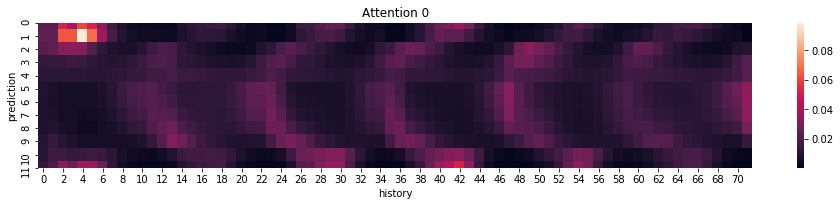

In [20]:
pred_idx = 200
enc_x = torch.tensor(series[pred_idx - enc_lens: pred_idx]).unsqueeze(0).float()
cat_x = torch.tensor(month[pred_idx-enc_lens: pred_idx + dec_lens]).unsqueeze(0).unsqueeze(2).long()
y_pred, attns = model.predict(enc_x, dec_lens, category_x=cat_x, use_move_scale=True, return_attns=True)
plot_attentions(attns)

## 4. Seq2Seq(Attention 4)

In [21]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.1,
        'hidden_size': 128,
        'teacher_forcing_rate': 0.5,
        'n_head': 4,
        'use_attn': True,
        'trans_hidden_size': 4,
        'trans_continuous_var': None,
        'trans_category_var': [(13, 2)],
        'trans_bidirectional': True,
        'trans_rnn_type': 'LSTM',
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = Seq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 2 / 17, loss 0.731:  12%|█▏        | 2/17 [00:00<00:01, 11.14it/s]

epoch 1 / 50: train loss 1.055 val loss 1.099 RMSE 174.914
create model path: /home/zhouzr/project/Deep-Time-Series-Prediction/notebooks/logs


batch 1 / 17, loss 0.763:   6%|▌         | 1/17 [00:00<00:02,  6.85it/s]

epoch 2 / 50: train loss 0.848 val loss 0.971 RMSE 167.287


batch 3 / 17, loss 0.714:  12%|█▏        | 2/17 [00:00<00:00, 16.07it/s]

epoch 3 / 50: train loss 0.810 val loss 0.927 RMSE 164.324


batch 2 / 17, loss 0.759:  12%|█▏        | 2/17 [00:00<00:01, 11.27it/s]

epoch 4 / 50: train loss 0.766 val loss 0.901 RMSE 161.712


batch 1 / 17, loss 0.719:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 5 / 50: train loss 0.757 val loss 0.899 RMSE 161.588


batch 2 / 17, loss 0.678:  12%|█▏        | 2/17 [00:00<00:01, 14.00it/s]

epoch 6 / 50: train loss 0.752 val loss 0.901 RMSE 159.958


batch 2 / 17, loss 0.659:  12%|█▏        | 2/17 [00:00<00:01, 14.61it/s]

epoch 7 / 50: train loss 0.698 val loss 0.813 RMSE 152.476


batch 1 / 17, loss 0.665:   6%|▌         | 1/17 [00:00<00:02,  6.66it/s]

epoch 8 / 50: train loss 0.651 val loss 0.807 RMSE 152.238


batch 2 / 17, loss 0.603:  12%|█▏        | 2/17 [00:00<00:01, 12.73it/s]

epoch 9 / 50: train loss 0.611 val loss 0.804 RMSE 151.848


batch 2 / 17, loss 0.570:  12%|█▏        | 2/17 [00:00<00:01, 11.35it/s]

epoch 10 / 50: train loss 0.616 val loss 0.783 RMSE 149.992


batch 1 / 17, loss 0.690:   6%|▌         | 1/17 [00:00<00:01,  9.87it/s]

epoch 11 / 50: train loss 0.588 val loss 0.765 RMSE 148.142


batch 1 / 17, loss 0.504:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 12 / 50: train loss 0.565 val loss 0.816 RMSE 151.477


batch 1 / 17, loss 0.451:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 13 / 50: train loss 0.604 val loss 0.851 RMSE 156.867


batch 1 / 17, loss 0.456:   6%|▌         | 1/17 [00:00<00:01,  9.98it/s]

epoch 14 / 50: train loss 0.537 val loss 0.725 RMSE 142.606


batch 1 / 17, loss 0.545:   6%|▌         | 1/17 [00:00<00:01,  9.14it/s]

epoch 15 / 50: train loss 0.516 val loss 0.736 RMSE 144.502


batch 1 / 17, loss 0.452:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 16 / 50: train loss 0.493 val loss 0.747 RMSE 145.285


batch 2 / 17, loss 0.407:  12%|█▏        | 2/17 [00:00<00:01, 14.93it/s]

epoch 17 / 50: train loss 0.464 val loss 0.697 RMSE 140.141


batch 1 / 17, loss 0.456:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 18 / 50: train loss 0.476 val loss 0.659 RMSE 136.171


batch 2 / 17, loss 0.361:  12%|█▏        | 2/17 [00:00<00:01, 13.85it/s]

epoch 19 / 50: train loss 0.452 val loss 0.663 RMSE 136.713


batch 1 / 17, loss 0.441:   6%|▌         | 1/17 [00:00<00:01,  8.72it/s]

epoch 20 / 50: train loss 0.420 val loss 0.636 RMSE 134.769


batch 2 / 17, loss 0.335:  12%|█▏        | 2/17 [00:00<00:01, 12.06it/s]

epoch 21 / 50: train loss 0.419 val loss 0.630 RMSE 133.451


batch 1 / 17, loss 0.373:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 22 / 50: train loss 0.391 val loss 0.602 RMSE 129.517


batch 1 / 17, loss 0.422:   6%|▌         | 1/17 [00:00<00:01,  9.99it/s]

epoch 23 / 50: train loss 0.375 val loss 0.596 RMSE 128.097


batch 2 / 17, loss 0.375:  12%|█▏        | 2/17 [00:00<00:01, 14.33it/s]

epoch 24 / 50: train loss 0.370 val loss 0.588 RMSE 126.907


batch 2 / 17, loss 0.318:  12%|█▏        | 2/17 [00:00<00:01, 13.46it/s]

epoch 25 / 50: train loss 0.348 val loss 0.590 RMSE 126.578


batch 2 / 17, loss 0.298:  12%|█▏        | 2/17 [00:00<00:00, 16.00it/s]

epoch 26 / 50: train loss 0.349 val loss 0.552 RMSE 121.573


batch 2 / 17, loss 0.260:  12%|█▏        | 2/17 [00:00<00:01, 13.31it/s]

epoch 27 / 50: train loss 0.322 val loss 0.551 RMSE 121.590


batch 1 / 17, loss 0.333:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 28 / 50: train loss 0.302 val loss 0.530 RMSE 117.080


batch 2 / 17, loss 0.454:  12%|█▏        | 2/17 [00:00<00:01, 14.91it/s]

epoch 29 / 50: train loss 0.296 val loss 0.528 RMSE 116.614


batch 1 / 17, loss 0.288:   6%|▌         | 1/17 [00:00<00:01,  8.91it/s]

epoch 30 / 50: train loss 0.273 val loss 0.523 RMSE 117.008


batch 3 / 17, loss 0.228:  12%|█▏        | 2/17 [00:00<00:00, 16.68it/s]

epoch 31 / 50: train loss 0.265 val loss 0.502 RMSE 113.239


batch 3 / 17, loss 0.251:  12%|█▏        | 2/17 [00:00<00:00, 15.18it/s]

epoch 32 / 50: train loss 0.271 val loss 0.535 RMSE 118.974


batch 3 / 17, loss 0.222:  12%|█▏        | 2/17 [00:00<00:00, 15.26it/s]

epoch 33 / 50: train loss 0.261 val loss 0.541 RMSE 118.182


batch 2 / 17, loss 0.220:  12%|█▏        | 2/17 [00:00<00:01, 13.65it/s]

epoch 34 / 50: train loss 0.274 val loss 0.485 RMSE 110.154


batch 2 / 17, loss 0.228:  12%|█▏        | 2/17 [00:00<00:01, 12.72it/s]

epoch 35 / 50: train loss 0.298 val loss 0.494 RMSE 110.883


batch 2 / 17, loss 0.245:  12%|█▏        | 2/17 [00:00<00:01, 14.39it/s]

epoch 36 / 50: train loss 0.254 val loss 0.475 RMSE 108.336


batch 2 / 17, loss 0.289:  12%|█▏        | 2/17 [00:00<00:01, 13.88it/s]

epoch 37 / 50: train loss 0.230 val loss 0.460 RMSE 105.878


batch 2 / 17, loss 0.257:  12%|█▏        | 2/17 [00:00<00:01, 10.64it/s]

epoch 38 / 50: train loss 0.228 val loss 0.461 RMSE 105.567


batch 2 / 17, loss 0.269:  12%|█▏        | 2/17 [00:00<00:01, 11.72it/s]

epoch 39 / 50: train loss 0.230 val loss 0.448 RMSE 103.209


batch 2 / 17, loss 0.221:  12%|█▏        | 2/17 [00:00<00:01, 12.22it/s]

epoch 40 / 50: train loss 0.214 val loss 0.441 RMSE 102.488


batch 2 / 17, loss 0.177:  12%|█▏        | 2/17 [00:00<00:00, 15.79it/s]

epoch 41 / 50: train loss 0.213 val loss 0.437 RMSE 101.451


batch 2 / 17, loss 0.190:  12%|█▏        | 2/17 [00:00<00:00, 15.85it/s]

epoch 42 / 50: train loss 0.204 val loss 0.438 RMSE 100.981


batch 1 / 17, loss 0.188:   6%|▌         | 1/17 [00:00<00:01,  9.98it/s]

epoch 43 / 50: train loss 0.206 val loss 0.432 RMSE 100.088


batch 2 / 17, loss 0.161:  12%|█▏        | 2/17 [00:00<00:01, 14.37it/s]

epoch 44 / 50: train loss 0.206 val loss 0.430 RMSE 99.942


batch 2 / 17, loss 0.230:  12%|█▏        | 2/17 [00:00<00:01, 12.30it/s]

epoch 45 / 50: train loss 0.204 val loss 0.425 RMSE 99.023


batch 2 / 17, loss 0.179:  12%|█▏        | 2/17 [00:00<00:01, 11.64it/s]

epoch 46 / 50: train loss 0.192 val loss 0.426 RMSE 98.980


batch 1 / 17, loss 0.190:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 47 / 50: train loss 0.197 val loss 0.425 RMSE 98.768


batch 1 / 17, loss 0.201:   6%|▌         | 1/17 [00:00<00:01,  8.39it/s]

epoch 48 / 50: train loss 0.189 val loss 0.424 RMSE 98.664


batch 2 / 17, loss 0.274:  12%|█▏        | 2/17 [00:00<00:01, 14.40it/s]

epoch 49 / 50: train loss 0.196 val loss 0.422 RMSE 98.367


batch 17 / 17, loss 0.186: 100%|██████████| 17/17 [00:01<00:00,  9.36it/s]


epoch 50 / 50: train loss 0.192 val loss 0.422 RMSE 98.308
best model save in /home/zhouzr/project/Deep-Time-Series-Prediction/notebooks/logs/Seq2Seq_epoch_50_0.422.pkl


In [22]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.192, valid loss: 0.422, test loss :0.534, test RMSE :111.768, 


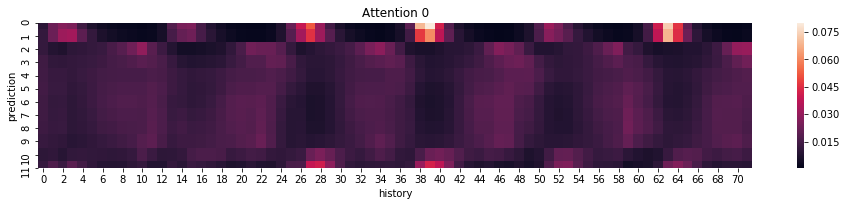

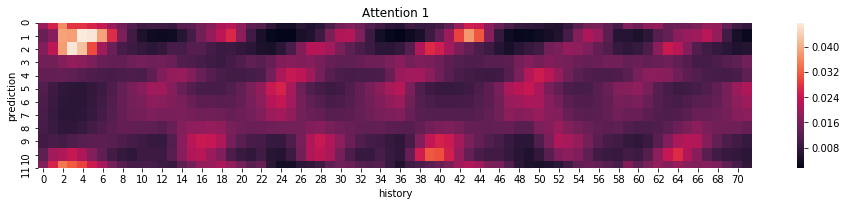

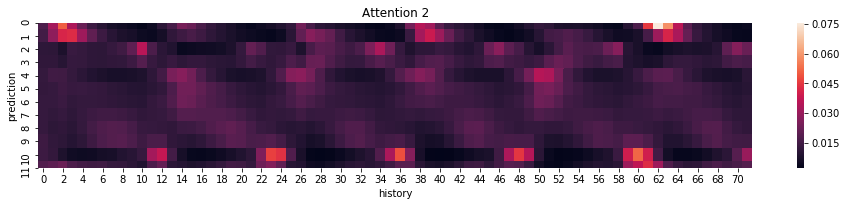

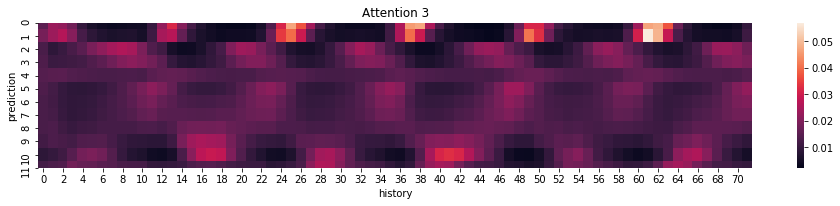

In [23]:
pred_idx = 200
enc_x = torch.tensor(series[pred_idx - enc_lens: pred_idx]).unsqueeze(0).float()
cat_x = torch.tensor(month[pred_idx-enc_lens: pred_idx + dec_lens]).unsqueeze(0).unsqueeze(2).long()
y_pred, attns = model.predict(enc_x, dec_lens, category_x=cat_x, use_move_scale=True, return_attns=True)
plot_attentions(attns)

## 5. Simple WaveNet

In [24]:
dataset = SimpleWaveNetDataSet(series, enc_lens, dec_lens)
idxes = list(range(len(dataset)))
train_idxes, _idxes = walk_forward_split(idxes, enc_lens, dec_lens, test_size=n_test + n_val)
valid_idxes, test_idxes = walk_forward_split(_idxes, enc_lens, dec_lens, test_size=n_test)

trn_set = Subset(dataset, train_idxes)
val_set = Subset(dataset, valid_idxes)
test_set = Subset(dataset, test_idxes)
trn_ld = DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_ld = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_ld = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [27]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'dilation': [1, 2, 4, 8, 16, 32, 64],
        'dropout': 0.2,
        'residual_channels': 72,
        'teacher_forcing_rate': 0.5,
        'use_move_scale': True,
    }

compile_params = {
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
    'loss_fn': 'MSELoss',
}

In [28]:
model = SimpleWaveNet(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 3 / 17, loss 0.842:  12%|█▏        | 2/17 [00:00<00:00, 18.95it/s]

epoch 1 / 50: train loss 1.057 val loss 1.173 RMSE 179.898


batch 3 / 17, loss 0.807:  12%|█▏        | 2/17 [00:00<00:00, 19.24it/s]

epoch 2 / 50: train loss 0.881 val loss 0.939 RMSE 163.532


batch 3 / 17, loss 0.660:  12%|█▏        | 2/17 [00:00<00:00, 18.45it/s]

epoch 3 / 50: train loss 0.766 val loss 0.876 RMSE 156.244


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 4 / 50: train loss 0.720 val loss 0.868 RMSE 155.451


batch 3 / 17, loss 0.606:  12%|█▏        | 2/17 [00:00<00:00, 19.20it/s]

epoch 5 / 50: train loss 0.707 val loss 0.855 RMSE 154.125


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 6 / 50: train loss 0.680 val loss 0.801 RMSE 148.029


batch 3 / 17, loss 0.542:  12%|█▏        | 2/17 [00:00<00:00, 19.12it/s]

epoch 7 / 50: train loss 0.609 val loss 0.844 RMSE 153.834


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 8 / 50: train loss 0.548 val loss 0.748 RMSE 143.691


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 9 / 50: train loss 0.494 val loss 0.734 RMSE 140.205


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 10 / 50: train loss 0.453 val loss 0.679 RMSE 134.601


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 11 / 50: train loss 0.403 val loss 0.666 RMSE 132.383


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 12 / 50: train loss 0.374 val loss 0.621 RMSE 127.452


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 13 / 50: train loss 0.342 val loss 0.564 RMSE 119.600


batch 1 / 17, loss 0.281:   6%|▌         | 1/17 [00:00<00:02,  6.15it/s]

epoch 14 / 50: train loss 0.312 val loss 0.540 RMSE 114.267


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 15 / 50: train loss 0.288 val loss 0.531 RMSE 113.396


batch 3 / 17, loss 0.215:  12%|█▏        | 2/17 [00:00<00:00, 18.71it/s]

epoch 16 / 50: train loss 0.277 val loss 0.527 RMSE 111.443


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 17 / 50: train loss 0.262 val loss 0.453 RMSE 102.037


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 18 / 50: train loss 0.254 val loss 0.436 RMSE 100.543


batch 3 / 17, loss 0.188:  12%|█▏        | 2/17 [00:00<00:00, 19.00it/s]

epoch 19 / 50: train loss 0.243 val loss 0.399 RMSE 93.799


batch 4 / 17, loss 0.188:  12%|█▏        | 2/17 [00:00<00:00, 19.52it/s]

epoch 20 / 50: train loss 0.231 val loss 0.401 RMSE 93.277


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 21 / 50: train loss 0.223 val loss 0.364 RMSE 87.506


batch 1 / 17, loss 0.181:   0%|          | 0/17 [00:00<?, ?it/s]

epoch 22 / 50: train loss 0.214 val loss 0.371 RMSE 91.152


batch 3 / 17, loss 0.186:  12%|█▏        | 2/17 [00:00<00:00, 16.50it/s]

epoch 23 / 50: train loss 0.209 val loss 0.332 RMSE 84.243


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 24 / 50: train loss 0.208 val loss 0.328 RMSE 83.592


batch 3 / 17, loss 0.203:  18%|█▊        | 3/17 [00:00<00:00, 20.42it/s]

epoch 25 / 50: train loss 0.201 val loss 0.308 RMSE 78.556


batch 4 / 17, loss 0.159:  18%|█▊        | 3/17 [00:00<00:00, 21.04it/s]

epoch 26 / 50: train loss 0.204 val loss 0.325 RMSE 82.689


batch 3 / 17, loss 0.170:  12%|█▏        | 2/17 [00:00<00:00, 19.60it/s]

epoch 27 / 50: train loss 0.185 val loss 0.306 RMSE 82.197


batch 3 / 17, loss 0.150:  12%|█▏        | 2/17 [00:00<00:00, 18.95it/s]

epoch 28 / 50: train loss 0.190 val loss 0.287 RMSE 76.511


batch 3 / 17, loss 0.181:  18%|█▊        | 3/17 [00:00<00:00, 20.94it/s]

epoch 29 / 50: train loss 0.184 val loss 0.283 RMSE 77.379


batch 3 / 17, loss 0.204:  12%|█▏        | 2/17 [00:00<00:00, 17.90it/s]

epoch 30 / 50: train loss 0.185 val loss 0.269 RMSE 73.755


batch 3 / 17, loss 0.202:  12%|█▏        | 2/17 [00:00<00:00, 17.90it/s]

epoch 31 / 50: train loss 0.179 val loss 0.264 RMSE 74.897


batch 3 / 17, loss 0.197:  12%|█▏        | 2/17 [00:00<00:00, 18.83it/s]

epoch 32 / 50: train loss 0.186 val loss 0.279 RMSE 75.156


batch 3 / 17, loss 0.194:  12%|█▏        | 2/17 [00:00<00:00, 18.35it/s]

epoch 33 / 50: train loss 0.184 val loss 0.295 RMSE 76.422


batch 3 / 17, loss 0.176:  12%|█▏        | 2/17 [00:00<00:00, 18.53it/s]

epoch 34 / 50: train loss 0.174 val loss 0.259 RMSE 73.251


batch 3 / 17, loss 0.190:  12%|█▏        | 2/17 [00:00<00:00, 17.90it/s]

epoch 35 / 50: train loss 0.178 val loss 0.275 RMSE 74.150


batch 3 / 17, loss 0.150:  12%|█▏        | 2/17 [00:00<00:00, 18.34it/s]

epoch 36 / 50: train loss 0.177 val loss 0.258 RMSE 71.918


batch 3 / 17, loss 0.159:  12%|█▏        | 2/17 [00:00<00:00, 18.66it/s]

epoch 37 / 50: train loss 0.169 val loss 0.247 RMSE 70.740


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 38 / 50: train loss 0.176 val loss 0.255 RMSE 72.002


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 39 / 50: train loss 0.172 val loss 0.253 RMSE 70.386


batch 4 / 17, loss 0.193:  18%|█▊        | 3/17 [00:00<00:00, 21.23it/s]

epoch 40 / 50: train loss 0.173 val loss 0.246 RMSE 70.237


batch 3 / 17, loss 0.181:  18%|█▊        | 3/17 [00:00<00:00, 20.08it/s]

epoch 41 / 50: train loss 0.170 val loss 0.252 RMSE 69.373


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 42 / 50: train loss 0.172 val loss 0.237 RMSE 69.141


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 43 / 50: train loss 0.171 val loss 0.245 RMSE 69.418


batch 3 / 17, loss 0.155:  12%|█▏        | 2/17 [00:00<00:00, 16.88it/s]

epoch 44 / 50: train loss 0.170 val loss 0.242 RMSE 69.430


batch 3 / 17, loss 0.164:  12%|█▏        | 2/17 [00:00<00:00, 17.33it/s]

epoch 45 / 50: train loss 0.171 val loss 0.241 RMSE 68.726


batch 3 / 17, loss 0.156:  12%|█▏        | 2/17 [00:00<00:01, 14.71it/s]

epoch 46 / 50: train loss 0.167 val loss 0.242 RMSE 69.493


batch 3 / 17, loss 0.198:  12%|█▏        | 2/17 [00:00<00:00, 18.36it/s]

epoch 47 / 50: train loss 0.172 val loss 0.244 RMSE 69.022


batch 4 / 17, loss 0.130:  18%|█▊        | 3/17 [00:00<00:00, 20.72it/s]

epoch 48 / 50: train loss 0.165 val loss 0.242 RMSE 68.454


batch 4 / 17, loss 0.164:  18%|█▊        | 3/17 [00:00<00:00, 20.88it/s]

epoch 49 / 50: train loss 0.163 val loss 0.240 RMSE 68.773


batch 17 / 17, loss 0.155: 100%|██████████| 17/17 [00:00<00:00, 19.22it/s]


epoch 50 / 50: train loss 0.171 val loss 0.237 RMSE 68.203
best model save in /home/zhouzr/project/Deep-Time-Series-Prediction/notebooks/logs/SimpleWaveNet_epoch_42_0.237.pkl


In [29]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f} '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f} '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f} '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.093 valid loss: 0.237 test loss :0.355 test RMSE :84.503, 


## 6. Summary

| model | num of attention | RMSE(test) | loss(test) | loss(val) | loss(train)|
|:-:| :-: | :-:| :-:| :-:| :-:|
| SimpleSeq2Seq | / | 141.54 | 0.725|0.682|0.476|
| Seq2Seq| 0| 120.7| 0.571| 0.491| 0.279|
| Seq2Seq| 1| 113.9| 0.532| 0.427| 0.222|
| Seq2Seq| 4| 111.7 | 0.534| 0.422| 0.192|
| SimpleWaveNet| / | 84.5 | 0.355 | 0.237| 0.093|